In [1]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

np.random.seed(0)
%matplotlib inline

In [2]:
# Load the training data
X = np.genfromtxt('data/X_train.txt', delimiter=None)
Y = np.genfromtxt('data/Y_train.txt', delimiter=None)

# And the test features
Xte = np.genfromtxt('data/X_test.txt', delimiter=None)

### Baseline Predictions (Decision Tree)

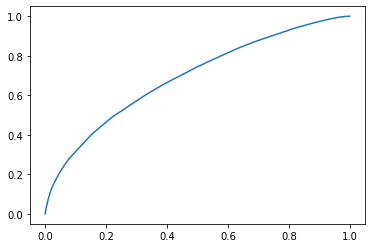

Training AUC for maxDepth=8, minParent=500: 0.6920437816235144


In [3]:
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y, 0.50)
learner = ml.dtree.treeClassify(Xtr, Ytr, maxDepth=8, minParent=500)
ROCtr = learner.roc(Xtr, Ytr)
AUCtr = learner.auc(Xtr, Ytr)
plt.plot(ROCtr[0], ROCtr[1])
plt.show()
print("Training AUC for maxDepth=8, minParent=500:", AUCtr)

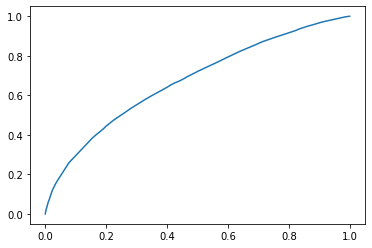

Validation AUC for maxDepth=8, minParent=500: 0.6742744978932247


In [4]:
ROCva = learner.roc(Xva, Yva)
AUCva = learner.auc(Xva, Yva)
plt.plot(ROCva[0], ROCva[1])
plt.show()
print("Validation AUC for maxDepth=8, minParent=500:", AUCva)

In [5]:
learner = ml.dtree.treeClassify(X, Y, maxDepth=8, minParent=500)
Xte = np.genfromtxt('data/X_test.txt', delimiter=None)
Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T
np.savetxt('Y_submit.txt',Yte,"%d, %.2f",header="ID,Prob1",comments="",delimiter=",")

### Gradient Boosted Trees

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC


In [7]:
XSmall = X[::50]
YSmall = Y[::50]
#Xtr, Xva, Ytr, Yva = ml.splitData(XSmall, YSmall, 0.50)
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y, 0.50)

In [8]:
models = list()
degrees = [i for i in range(1, 10)]
indices = [i for i in range(len(degrees))]

for degree in degrees:
    boostedTree = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=degree),
        n_estimators = 60)
    boostedTree.fit(Xtr, Ytr)
    models.append(boostedTree)

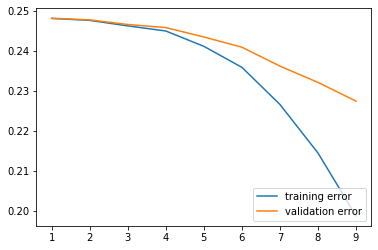

In [9]:
errTr = list()
errVa = list()
for model in models:
    preds = model.predict_proba(Xtr)
    errTr.append(mean_squared_error(Ytr, preds[:,1]))
    preds = model.predict_proba(Xva)
    errVa.append(mean_squared_error(Yva, preds[:,1]))
    
if len(models) > 1:
    xs = [i for i in degrees]
    plt.plot(xs, errTr, label='training error')
    plt.plot(xs, errVa, label='validation error')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Training error:", errTr[0])
    print("Validation error:", errVa[0])


degree: 6
Training Accuracy: 0.76708
Validation Accuracy: 0.71073


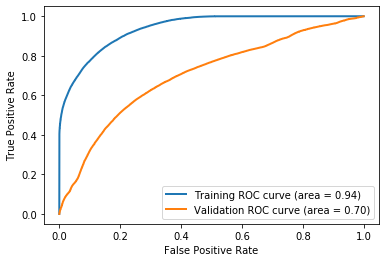

In [10]:
maxAuc = 0
maxModel = 0
for i, model in enumerate(models):
    predsTr = model.predict_proba(Xtr)
    fprTr, tprTr, thresholdsTr = metrics.roc_curve(Ytr, predsTr[:, 1])
    predsVa = model.predict_proba(Xva)
    fprVa, tprVa, thresholdsVa = metrics.roc_curve(Yva, predsVa[:, 1])
    roc_aucTr = roc_auc_score(Ytr, predsTr[:, 1])
    roc_aucVa = roc_auc_score(Yva, predsVa[:, 1])
    if maxAuc < roc_aucVa:
        maxAuc = roc_aucVa
        maxModel = i
        
model = models[maxModel]
print("degree:", degrees[maxModel])
print("Training Accuracy:",metrics.accuracy_score(Ytr, model.predict(Xtr)))
print("Validation Accuracy:",metrics.accuracy_score(Yva, model.predict(Xva)))
plt.figure()
lw = 2
plt.plot(fprTr, tprTr,
         lw=lw, label='Training ROC curve (area = %0.2f)' % roc_aucTr)
plt.plot(fprVa, tprVa,
         lw=lw, label='Validation ROC curve (area = %0.2f)' % roc_aucVa)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### KNN Classifier

In [16]:
XSmall = X[::50]
YSmall = Y[::50]
#Xtr, Xva, Ytr, Yva = ml.splitData(XSmall, YSmall, 0.50)
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y, 0.50)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
models = list()
degrees = [i for i in range(1, 100, 10)]
indices = [i for i in range(len(degrees))]

for degree in degrees:
    knn = KNeighborsClassifier(n_neighbors=degree)
    knn.fit(Xtr, Ytr)
    models.append(knn)

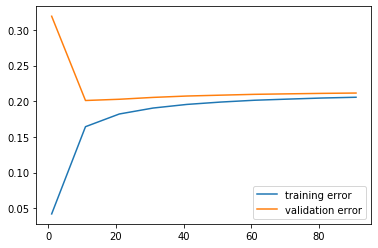

In [18]:
errTr = list()
errVa = list()
for model in models:
    preds = model.predict_proba(Xtr)
    errTr.append(mean_squared_error(Ytr, preds[:,1]))
    preds = model.predict_proba(Xva)
    errVa.append(mean_squared_error(Yva, preds[:,1]))
    
if len(models) > 1:
    xs = [i for i in degrees]
    plt.plot(xs, errTr, label='training error')
    plt.plot(xs, errVa, label='validation error')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Training error:", errTr[0])
    print("Validation error:", errVa[0])


degree: 11
Training Accuracy: 0.75398
Validation Accuracy: 0.69736


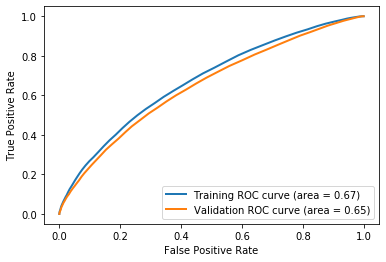

In [19]:
maxAuc = 0
maxModel = 0
for i, model in enumerate(models):
    predsTr = model.predict_proba(Xtr)
    fprTr, tprTr, thresholdsTr = metrics.roc_curve(Ytr, predsTr[:, 1])
    predsVa = model.predict_proba(Xva)
    fprVa, tprVa, thresholdsVa = metrics.roc_curve(Yva, predsVa[:, 1])
    roc_aucTr = roc_auc_score(Ytr, predsTr[:, 1])
    roc_aucVa = roc_auc_score(Yva, predsVa[:, 1])
    if maxAuc < roc_aucVa:
        maxAuc = roc_aucVa
        maxModel = i
        
model = models[maxModel]
print("degree:", degrees[maxModel])
print("Training Accuracy:",metrics.accuracy_score(Ytr, model.predict(Xtr)))
print("Validation Accuracy:",metrics.accuracy_score(Yva, model.predict(Xva)))
plt.figure()
lw = 2
plt.plot(fprTr, tprTr,
         lw=lw, label='Training ROC curve (area = %0.2f)' % roc_aucTr)
plt.plot(fprVa, tprVa,
         lw=lw, label='Validation ROC curve (area = %0.2f)' % roc_aucVa)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()